# Netflix Content Trends — Data Cleaning & EDA Notebook

This notebook walks through the full pipeline for the Netflix dataset: environment setup, loading, cleaning, exporting a tidy dataset, and generating exploratory visualizations.

## Overview & Table of Contents

1. Section 1 – Project setup & environment
2. Section 2 – Install or verify dependencies
3. Section 3 – VS Code notebook configuration tips
4. Section 4 – Load and preview the raw dataset
5. Section 5 – Data cleaning & preprocessing helpers
6. Section 6 – Export cleaned dataset
7. Section 7 – Exploratory plots

Each section is self-contained and can be run top-to-bottom.

In [30]:
# Section 1: Project setup & environment
import sys
import platform

print('Python executable:', sys.executable)
print('Python version:', sys.version)
print('Platform:', platform.platform())

try:
    import pkgutil
    installed = sorted([m.name for m in pkgutil.iter_modules()])
    print('Number of available modules:', len(installed))
except Exception as e:
    print('Could not list installed modules:', e)


Python executable: c:\Program Files\Python312\python.exe
Python version: 3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
Number of available modules: 690
Number of available modules: 690


In [31]:
# Section 2: Install or verify dependencies (optional)
# NOTE: Running pip inside a notebook modifies the active kernel environment.
# Uncomment the pip line if you need to install requirements.

# !pip install -r '../requirements.txt'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)


pandas version: 2.1.4
numpy version: 1.26.4


In [32]:
# Section 4: Load and preview the raw dataset
from pathlib import Path
data_csv = Path('..') / 'Netflix Dataset.csv'
print('Expecting dataset at:', data_csv.resolve())

if data_csv.exists():
    df = pd.read_csv(data_csv)
    print('Loaded rows:', len(df))
    display(df.head())
    display(df.info())
    for col in ['type', 'listed_in', 'country']:
        if col in df.columns:
            print(f'\nValue counts for {col}')
            display(df[col].value_counts().head(10))
else:
    print('File not found. Please place "Netflix Dataset.csv" in the parent folder of this notebook.')


Expecting dataset at: C:\Users\Harsh Gupta HP\Downloads\data projecyt\Netflix Dataset.csv
Loaded rows: 7789
Loaded rows: 7789


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB


None

In [33]:
# Section 5: Data cleaning & preprocessing helpers
import re

# Column normalization

def normalize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df


def parse_dates(df: pd.DataFrame) -> pd.DataFrame:
    if 'date_added' in df.columns:
        df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        df['year_added'] = df['date_added'].dt.year
    return df


def clean_duration(df: pd.DataFrame) -> pd.DataFrame:
    if 'duration' in df.columns and 'type' in df.columns:
        df['duration_minutes'] = df.apply(
            lambda r: int(str(r['duration']).split()[0])
            if pd.notna(r['duration']) and str(r['type']).strip().lower() == 'movie'
            else np.nan,
            axis=1,
        )

        def parse_seasons(x):
            try:
                if pd.isna(x):
                    return np.nan
                return int(str(x).split()[0])
            except Exception:
                return np.nan

        df['seasons'] = df.apply(
            lambda r: parse_seasons(r['duration'])
            if pd.notna(r['duration']) and str(r['type']).strip().lower() == 'tv show'
            else np.nan,
            axis=1,
        )
    return df


def explode_genres(df: pd.DataFrame) -> pd.DataFrame:
    if 'listed_in' in df.columns:
        df['listed_in'] = df['listed_in'].fillna('Unknown')
        df['genre_list'] = df['listed_in'].apply(lambda s: [g.strip() for g in s.split(',')])
        df = df.explode('genre_list').rename(columns={'genre_list': 'genre'})
    return df


def normalize_countries(df: pd.DataFrame) -> pd.DataFrame:
    if 'country' in df.columns:
        df['country'] = df['country'].fillna('Unknown')
        df['country_list'] = df['country'].apply(lambda s: [c.strip() for c in str(s).split(',')])
        df = df.explode('country_list').rename(columns={'country_list': 'country_normalized'})
    return df


if 'df' in globals():
    print('Applying cleaning pipeline...')
    df = normalize_column_names(df)
    df = parse_dates(df)
    df = clean_duration(df)
    df = explode_genres(df)
    df = normalize_countries(df)
    print('After cleaning rows:', len(df))
    display(df.head())
else:
    print('Please run Section 4 first to create `df`.')


Applying cleaning pipeline...
After cleaning rows: 9576
After cleaning rows: 9576


,show_id,category,title,director,cast,country,release_date,rating,duration,type,description,duration_minutes,seasons,country_normalized
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,NaN,NaN,Brazil
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,NaN,NaN,Mexico
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",NaN,NaN,Singapore
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",NaN,NaN,United States
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...,NaN,NaN,United States


In [34]:
# Section 6: Export cleaned dataset
from pathlib import Path

output_dir = Path('..') / 'data'
output_dir.mkdir(parents=True, exist_ok=True)
cleaned_csv = output_dir / 'netflix_cleaned.csv'

if 'df' in globals():
    df.to_csv(cleaned_csv, index=False)
    print('Cleaned CSV saved to', cleaned_csv.resolve())
else:
    print('No cleaned dataframe found. Run Sections 4 and 5 first.')


Cleaned CSV saved to C:\Users\Harsh Gupta HP\Downloads\data projecyt\data\netflix_cleaned.csv
 C:\Users\Harsh Gupta HP\Downloads\data projecyt\data\netflix_cleaned.csv


## Section 7: Exploratory Data Analysis (plots)

Run the next cells to build aggregate tables and produce three core visuals:

1. Yearly counts of Movies vs TV Shows
2. Top 10 genres by title count
3. Top 10 countries by title count

All figures are saved to the `../figures/` directory for reuse in reports or presentations.

In [35]:
# Section 7.1: Prepare data for plotting
fig_dir = Path('..') / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

cleaned_path = Path('..') / 'data' / 'netflix_cleaned.csv'
if cleaned_path.exists():
    plot_df = pd.read_csv(cleaned_path)
else:
    plot_df = df.copy()

plot_df.columns = [c.strip().lower().replace(' ', '_') for c in plot_df.columns]

if 'year_added' in plot_df.columns:
    plot_df['year'] = plot_df['year_added']
elif 'release_year' in plot_df.columns:
    plot_df['year'] = plot_df['release_year']
else:
    plot_df['year'] = pd.to_datetime(plot_df.get('release_date', ''), errors='coerce').dt.year

plot_df['type'] = plot_df['type'].fillna('Unknown')

print('Plot dataframe rows:', len(plot_df))
plot_df.head()

Plot dataframe rows: 9576


,show_id,category,title,director,cast,country,release_date,rating,duration,type,description,duration_minutes,seasons,country_normalized,year
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,NaN,NaN,Brazil,2020.0
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,NaN,NaN,Mexico,2016.0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",NaN,NaN,Singapore,2018.0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",NaN,NaN,United States,2017.0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...,NaN,NaN,United States,2020.0


C:\Users\Harsh Gupta HP\AppData\Local\Temp\ipykernel_26172\3269480508.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


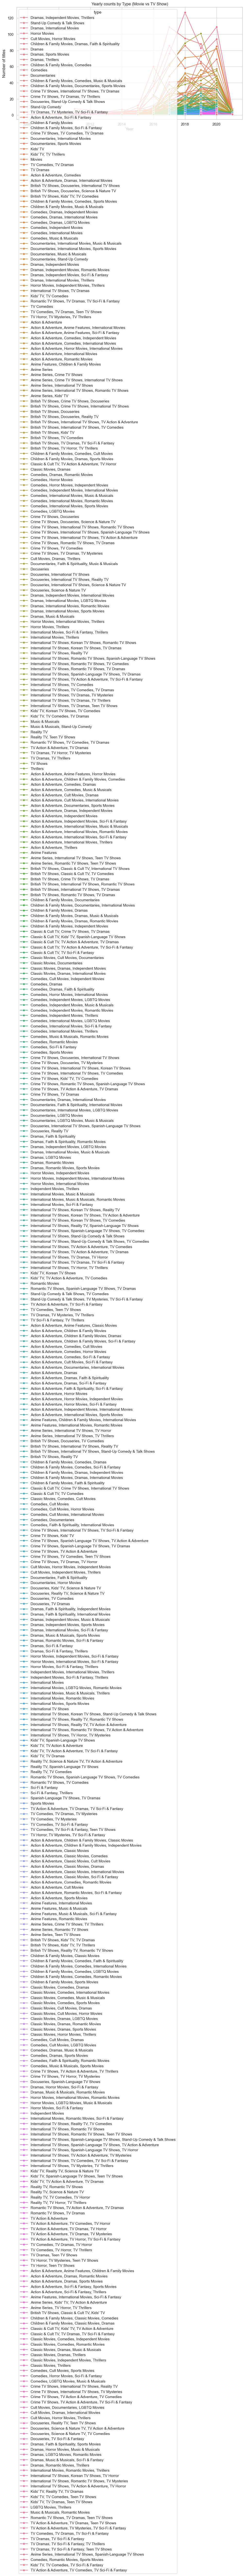

No genre column present to plot top genres.


In [36]:
# Section 7.2: Yearly trend and top genres plots
sns.set(style='whitegrid')

year_type = plot_df.groupby(['year', 'type']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=year_type, x='year', y='count', hue='type', marker='o')
ax.set_title('Yearly counts by Type (Movie vs TV Show)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of titles')
plt.tight_layout()
plt.savefig(fig_dir / 'yearly_type_counts.png', dpi=150)
plt.show()

if 'genre' in plot_df.columns:
    top_genres = plot_df['genre'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
    plt.title('Top 10 Genres')
    plt.xlabel('Number of titles')
    plt.tight_layout()
    plt.savefig(fig_dir / 'top_genres.png', dpi=150)
    plt.show()
else:
    print('No genre column present to plot top genres.')

C:\Users\Harsh Gupta HP\AppData\Local\Temp\ipykernel_26172\631778137.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')


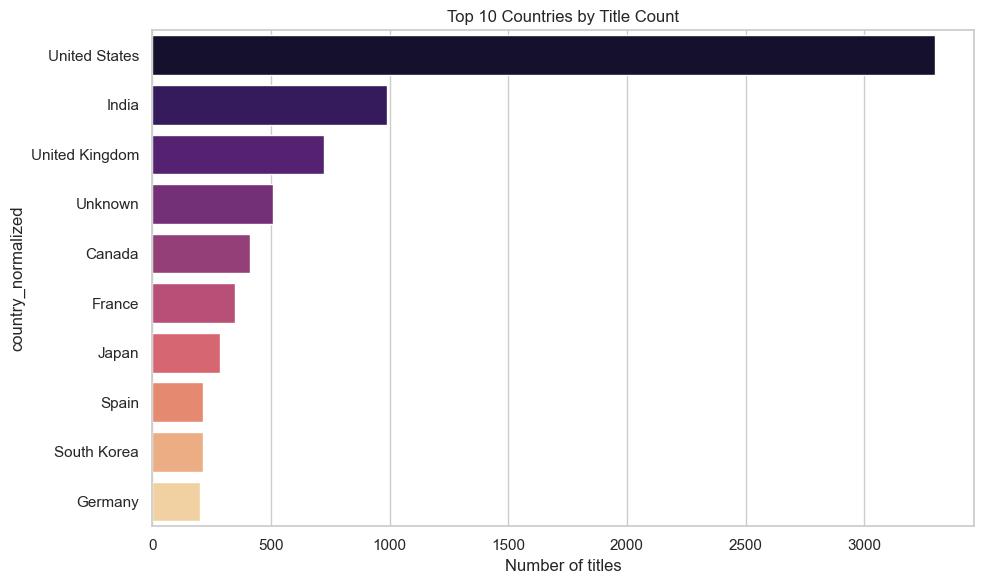

Saved figures to C:\Users\Harsh Gupta HP\Downloads\data projecyt\figures


In [37]:
# Section 7.3: Top countries plot
if 'country_normalized' in plot_df.columns:
    top_countries = plot_df['country_normalized'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')
    plt.title('Top 10 Countries by Title Count')
    plt.xlabel('Number of titles')
    plt.tight_layout()
    plt.savefig(fig_dir / 'top_countries.png', dpi=150)
    plt.show()
else:
    print('No country_normalized column present to plot top countries.')

print('Saved figures to', fig_dir.resolve())